In [ ]:
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
import os, sys, time
%matplotlib inline

# Feature Tracker

## Overview

Implements a corner detector and feature tracker that track features from the image sequence hotel.

In [ ]:
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym

data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

## Helper Functions

In [ ]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

folder = '/content/part1_images/'
im = readImages(folder, 51)

## Keypoint Selection

### Code

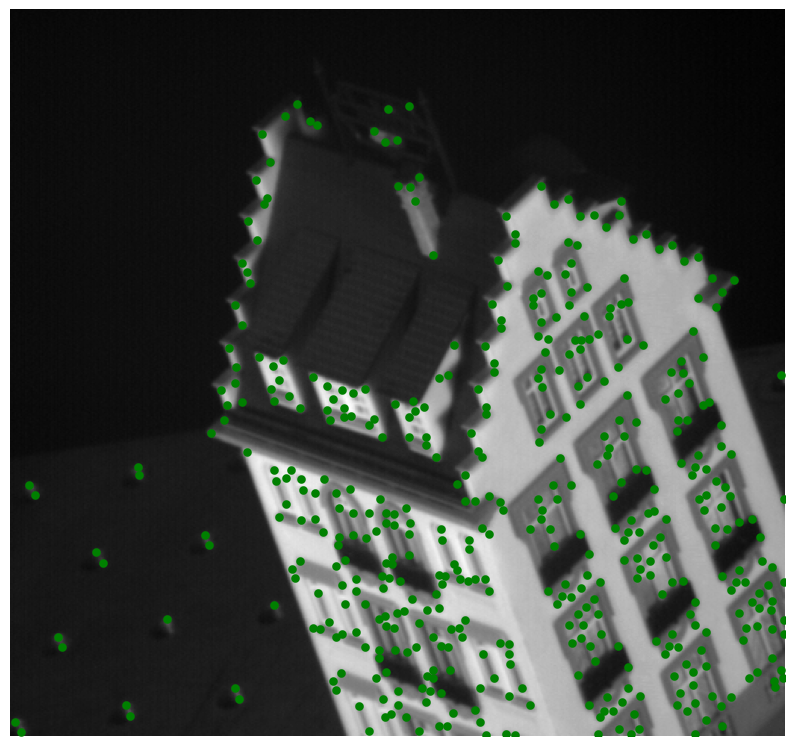

In [ ]:
import cv2
def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion

  Parameters:
    img: input image
    tau: threshold

  Output:
    keypoints : (N,2) array of [x,y] keypoints
  '''
  window_size = 7

  img = cv2.convertScaleAbs(img)

  grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  smooth_image = cv2.GaussianBlur(grayscale_image, (window_size, window_size), 0)

  x = cv2.Sobel(smooth_image, cv2.CV_64F, 1, 0, ksize=3)
  y = cv2.Sobel(smooth_image, cv2.CV_64F, 0, 1, ksize=3)

  Ix = x**2
  Iy = y**2
  Ixy = x*y

  Ixx = cv2.GaussianBlur(Ix, (5, 5), 0)
  Iyy = cv2.GaussianBlur(Iy, (5, 5), 0)
  Ixy2  = cv2.GaussianBlur(Ixy, (5, 5), 0)

  det = (Ixx * Iyy) - (Ixy2**2)
  trace = Ixx + Iyy
  r = det - 0.04 * (trace**2)

  range = r.max() - r.min()
  r = (r - r.min()) / range

  nms_window_size = 5
  max = ndimage.rank_filter(r, -1, footprint=np.ones((window_size, window_size)))
  keypoints = np.argwhere(r == max)
  filter = []
  for keypoint in keypoints:
    x_val, y_val = keypoint[0], keypoint[1]
    if r[x_val, y_val] > tau:
        filter.append(keypoint)
  keypoints = np.array(filter)
  keypoints = keypoints[:, [1, 0]]
  return keypoints

tau = 0.4997
key_pts = getKeypoints(im[0], tau)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(im[0], cv2.COLOR_BGR2GRAY), cmap='gray')
plt.scatter(key_pts[:, 0], key_pts[:, 1], color='g', s=10, linewidths=3)
plt.axis('off')
plt.show()

My implementation of getKeypoints() starts off with converting the image to grayscale for processing. Then the Gaussian Blur function is utilized to smooth the image and remove any unnecessary noise. The function then implements the cv2.sobel method to calculate the image gradients along the x and y axes. After this, the second moment matrix, Tensor m, is created from those x and y image gradient values. The top left value of the matrix is (Ix * Ix), which is computed by squaring the x axes gradient value. Similarly, the bottom right value of the matrix is (Iy * Iy), so we square the y axes gradient value. The top right and bottom left values of the matrix represent Ix * Iy, so we multiply the x value by the y value. After these values are obtained, we run it through the Gaussian Blur filter again to smooth out the matrix to decrease noise and increase accuracy at corner detection. The next code segment is to find the corner response f. First we compute the determinant of the matrix and the trace value. With these values we can find the response by doing the determinant - alpha * trace. The next part of the code normalizes the corner response, as without this too many corners were being detected. The final step of this function is the non maximum suppresion. This part is implemented by using the scipy.ndimage.rank_filter function. This gives us the largest element in each local window, so we can determine the location where the response is the maximum within that local window. Finally, only keypoints that are greater than tau are kept, as this removes all the weaker detected points. The points are converted to (x,y) format and returned.

## Feature Tracking

Applies the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.

### Code

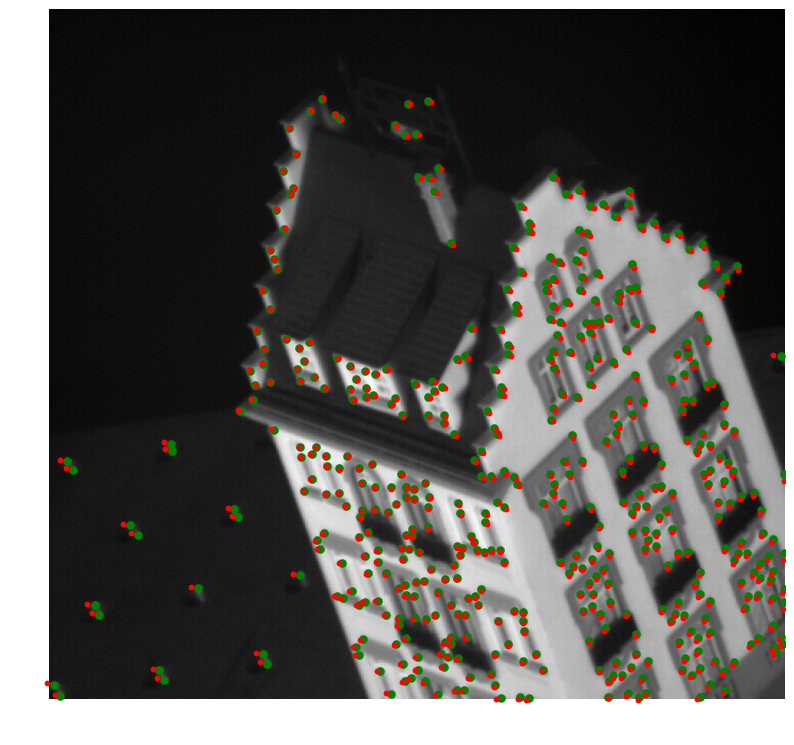

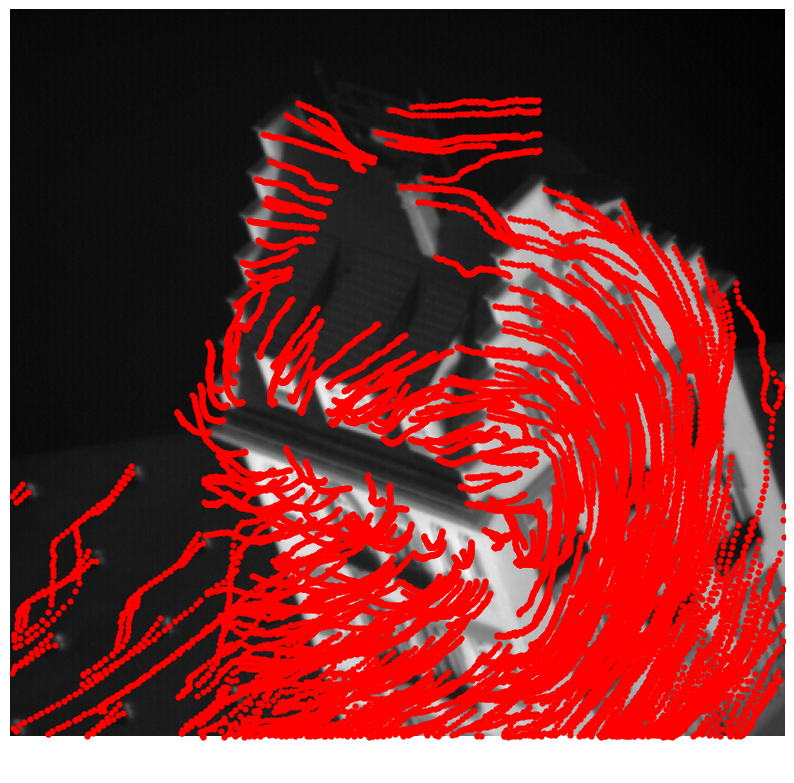

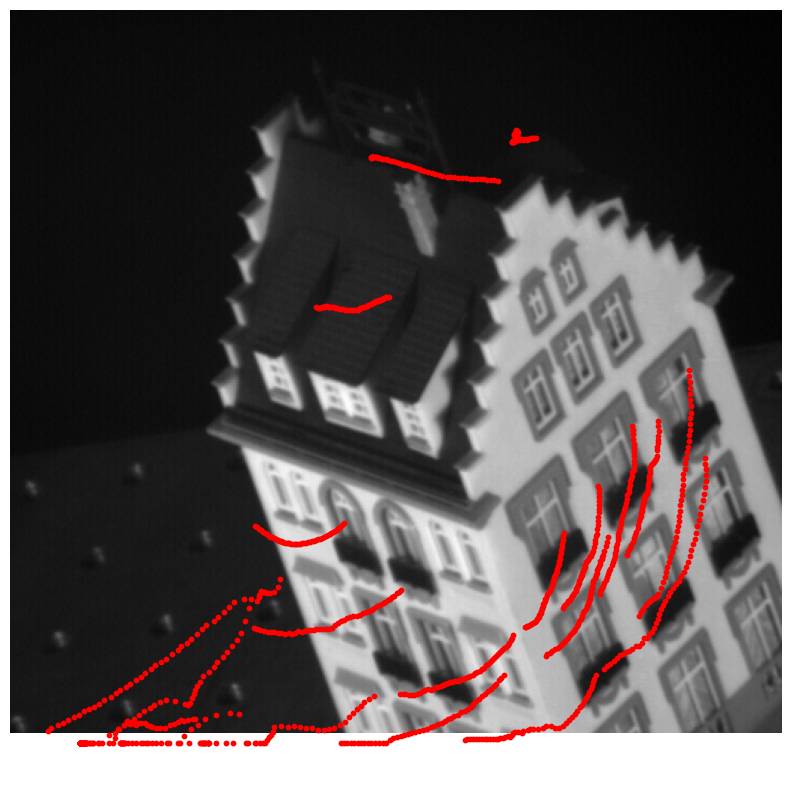

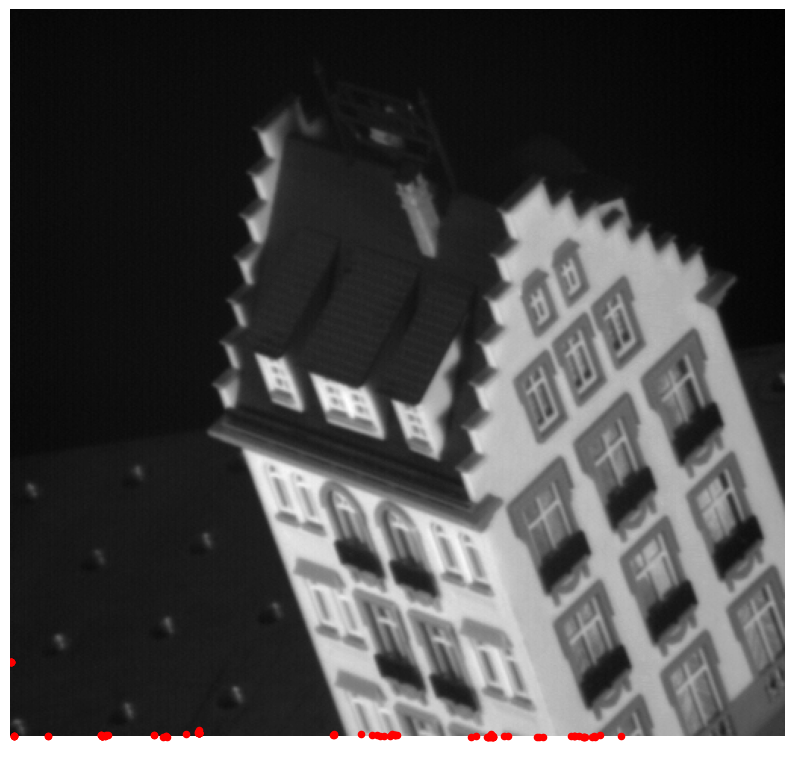

In [ ]:
import numpy as np
import cv2
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

def lucas_kanade_tracking(I1, I2, x, y, ws=15, max_iter=20, epsilon=0.01):

  '''
  Tracking using Lucas-Kanade algorithm

  Parameters:
    I1: first frame of input image sequence (grayscale)
    I2: second frame of input image sequence (grayscale)
    x: x locations of the keypoints in first frame
    y: y locations of the keypoints in first frame
    ws: local window size
    max_iter: number of iterations
    epsilon: threshold for checking convergence

  Output:
    new_x: newly calculated keypoints for second frame
    new_y: newly calculated keypoints for second frame
  '''

  I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
  I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

  I1 = I1.astype(np.float64)
  I2 = I2.astype(np.float64)

  I1_spline = RectBivariateSpline(np.arange(I1.shape[0]), np.arange(I1.shape[1]), I1)
  I2_spline = RectBivariateSpline(np.arange(I2.shape[0]), np.arange(I2.shape[1]), I2)

  Ix = cv2.Sobel(I1, cv2.CV_64F, 1, 0, ksize=3)
  Iy = cv2.Sobel(I1, cv2.CV_64F, 0, 1, ksize=3)

  Ix_spline = RectBivariateSpline(np.arange(Ix.shape[0]), np.arange(Ix.shape[1]), Ix)
  Iy_spline = RectBivariateSpline(np.arange(Iy.shape[0]), np.arange(Iy.shape[1]), Iy)

  new_keypoints = []

  for x_val, y_val in zip(x, y):
      u = 0.0
      v = 0.0
      for x in range(max_iter):
          x_wind, y_wind = np.meshgrid(np.linspace(x_val + u - ws // 2, x_val + u + ws // 2, ws), np.linspace(y_val + v - ws // 2, y_val + v + ws // 2, ws))

          Ix2 = Ix_spline.ev(y_wind, x_wind)
          Iy2 = Iy_spline.ev(y_wind, x_wind)
          It = I2_spline.ev(y_wind, x_wind) - I1_spline.ev(y_wind, x_wind)

          Ix_flat = Ix2.flatten()
          Iy_flat = Iy2.flatten()
          It_flat = It.flatten()

          A = np.vstack((Ix_flat, Iy_flat)).T
          B = -It_flat

          u_v, p1, p2, p3 = np.linalg.lstsq(A, B, rcond=None)
          u2, v2 = u_v

          u += u2
          v += v2

          if np.linalg.norm([u2, v2]) < epsilon:
              break

      new_keypoints.append((x_val + u, y_val + v))

  new_x = [kp[0] for kp in new_keypoints]
  new_y = [kp[1] for kp in new_keypoints]
  return new_x, new_y



key_pts = getKeypoints(im[0], tau)
new_x, new_y = lucas_kanade_tracking(im[0], im[1],key_pts[:, 0], key_pts[:, 1])

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(im[0], cv2.COLOR_BGR2GRAY), cmap='gray')
plt.scatter(key_pts[:, 0], key_pts[:, 1], color='g', s=10, linewidths=3)
plt.scatter(new_x,new_y,color='r',s=10, linewidths=1)
plt.axis('off')
plt.show()


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(im[0], cv2.COLOR_BGR2GRAY), cmap='gray')

key_pts = np.array(key_pts)

for i in range(1, len(im)):
    new_x, new_y = lucas_kanade_tracking(im[i-1], im[i], key_pts[:, 0], key_pts[:, 1])
    new_points = np.stack((new_x, new_y), axis=-1)
    in_frame = (new_points[:, 0] >= 0) & (new_points[:, 1] >= 0) & (new_points[:, 0] < im[i].shape[1])  & (new_points[:, 1] < im[i].shape[0])
    key_pts = new_points[in_frame]
    plt.scatter(key_pts[:, 0], key_pts[:, 1], color='r', s=12, linewidths=1)

plt.axis('off')
plt.show()


num_keypoints = 20
random_points = key_pts[np.random.choice(key_pts.shape[0], num_keypoints, replace=False)]
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(im[0], cv2.COLOR_BGR2GRAY), cmap='gray')

for point in random_points:
    current_point = np.array([point])
    for i in range(1, len(im)):
        new_x, new_y = lucas_kanade_tracking(im[i-1], im[i], current_point[:, 0], current_point[:, 1])
        current_point = np.stack((new_x, new_y), axis=-1)
        plt.scatter(new_x, new_y, color='r', s=10, linewidths=1)

plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(im[0], cv2.COLOR_BGR2GRAY), cmap='gray')
mask = np.zeros(len(key_pts), dtype=bool)

for x in range(1, len(im)):
    new_x, new_y = lucas_kanade_tracking(im[x-1], im[x], key_pts[:, 0], key_pts[:, 1])
    for y in range(len(new_x)):
        if new_x[y] < 0 or new_y[y] < 0 or new_x[y] >= im[x].shape[1] or new_y[y] >= im[x].shape[0]:
            mask[y] = True
        else:
            key_pts[y] = [new_x[y], new_y[y]]

out_of_frame = key_pts[mask]
plt.scatter(out_of_frame[:, 0], out_of_frame[:, 1], color='r', s=20, linewidths=1)

plt.axis('off')
plt.show()



